# Crear conexión SPARK

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Limpieza y Correlación").getOrCreate()

cores = spark._jsc.sc().getExecutorMemoryStatus().keySet().size()
print("Ejcución de las tareas en ", cores, "core(s) del sistema de cómputo actual")

Ejcución de las tareas en  1 core(s) del sistema de cómputo actual


# Carga de datos

*   dfxx_Inv: `RedVolucion_20250521_Limpio.csv`
*   dfxx_Int: `Internet_Fijo_Penetracion_Municipio_20250521_Limpio.csv`
*   dfxx_Icf: `Resultados_icfes_limpios.csv`

In [ ]:
from pyspark import SparkFiles
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define la ruta a tu dataset en Google Drive
dataset_path = '/content/drive/MyDrive/Resultados_icfes_limpios.csv'

df00_Icf = spark.read.csv(dataset_path, header=True, inferSchema=True)
df00_Icf.count()

1449756

In [ ]:
url_github = "https://raw.githubusercontent.com/Torrescjua/limpieza_datos/refs/heads/main/RedVolucion_20250521_Limpio.csv"
spark.sparkContext.addFile(url_github)

df00_Inv = spark.read.csv("file://" + SparkFiles.get("RedVolucion_20250521_Limpio.csv"), inferSchema=True, header=True)
df00_Inv.count()

6682

In [ ]:
url_github = "https://raw.githubusercontent.com/Torrescjua/limpieza_datos/refs/heads/main/Internet_Fijo_Penetracion_Municipio_20250521_Limpio.csv"
spark.sparkContext.addFile(url_github)

df00_Int = spark.read.csv("file://" + SparkFiles.get("Internet_Fijo_Penetracion_Municipio_20250521_Limpio.csv"), inferSchema=True, header=True)

# Renombramos solo esa columna para quitar el punto y el espacio
df00_Int = df00_Int.withColumnRenamed(
    "No. ACCESOS FIJOS A INTERNET",
    "ACESSO_FIJO_INTERNET"
)

df00_Int.count()

35578

# Inspección exploratoria

## Visión general - Resultados_icfes_limpios.csv

In [ ]:
df00_Icf.printSchema()

root
 |-- PERIODO: integer (nullable = true)
 |-- ESTU_TIPODOCUMENTO: string (nullable = true)
 |-- ESTU_CONSECUTIVO: string (nullable = true)
 |-- COLE_AREA_UBICACION: string (nullable = true)
 |-- COLE_BILINGUE: string (nullable = true)
 |-- COLE_CALENDARIO: string (nullable = true)
 |-- COLE_CARACTER: string (nullable = true)
 |-- COLE_COD_DANE_ESTABLECIMIENTO: long (nullable = true)
 |-- COLE_COD_DANE_SEDE: long (nullable = true)
 |-- COLE_COD_DEPTO_UBICACION: integer (nullable = true)
 |-- COLE_COD_MCPIO_UBICACION: integer (nullable = true)
 |-- COLE_CODIGO_ICFES: integer (nullable = true)
 |-- COLE_DEPTO_UBICACION: string (nullable = true)
 |-- COLE_GENERO: string (nullable = true)
 |-- COLE_JORNADA: string (nullable = true)
 |-- COLE_MCPIO_UBICACION: string (nullable = true)
 |-- COLE_NATURALEZA: string (nullable = true)
 |-- COLE_NOMBRE_ESTABLECIMIENTO: string (nullable = true)
 |-- COLE_NOMBRE_SEDE: string (nullable = true)
 |-- COLE_SEDE_PRINCIPAL: string (nullable = true)
 |

In [ ]:
df00_Icf.show(5, truncate=False)

+-------+------------------+----------------+-------------------+-------------+---------------+-----------------+-----------------------------+------------------+------------------------+------------------------+-----------------+--------------------+-----------+------------+--------------------+---------------+--------------------------------------------------------------+---------------------------------------------------------+-------------------+---------------------------+---------------------------+---------------------+---------------------+-----------------------+-----------------+------------------------+---------------+--------------------+-----------+-----------------------+-----------------+-----------------+----------------+---------------------+-----------------+------------------------------------+----------------------------------+--------------------+------------------+-------------------+--------------------+------------------+------------------+-------------+--------

In [ ]:
df00_Icf.describe().show()

+-------+-----------------+------------------+------------------+-------------------+-------------+---------------+-----------------+-----------------------------+--------------------+------------------------+------------------------+-----------------+--------------------+-----------+------------+--------------------+---------------+---------------------------+--------------------+-------------------+---------------------------+---------------------------+---------------------+---------------------+-----------------------+-----------------+------------------------+---------------+--------------------+-----------+-----------------------+-----------------+-----------------+----------------+---------------------+-----------------+--------------------+--------------------+--------------------+------------------+-------------------+--------------------+------------------+------------------+-------------+-----------------+------------------+------------------------+------------------+-------

In [ ]:
from pyspark.sql.functions import col, sum as _sum, when

df00_Icf.select([
    _sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in df00_Icf.columns
]).show()


+-------+------------------+----------------+-------------------+-------------+---------------+-------------+-----------------------------+------------------+------------------------+------------------------+-----------------+--------------------+-----------+------------+--------------------+---------------+---------------------------+----------------+-------------------+---------------------------+---------------------------+---------------------+---------------------+-----------------------+-----------------+------------------------+---------------+--------------------+-----------+-----------------------+-----------------+-----------------+----------------+---------------------+-----------------+-------------------+-------------------+--------------------+------------------+-------------------+--------------------+------------------+------------------+-------------+-----------+----------------+------------------------+----------------+--------------------+-----------+----+----------+

In [ ]:
numeric_cols_icf = [c for c, t in df00_Icf.dtypes if t in ("int", "bigint", "double", "float")]
df00_Icf.select(numeric_cols_icf) \
    .summary("count", "mean", "stddev", "min", "25%", "50%", "75%", "max") \
    .show()

+-------+-----------------+-----------------------------+--------------------+------------------------+------------------------+-----------------+---------------------------+---------------------------+---------------------+---------------------+-----------------+------------------+------------------------+------------------+--------------------+------------------+------------------+------------------+
|summary|          PERIODO|COLE_COD_DANE_ESTABLECIMIENTO|  COLE_COD_DANE_SEDE|COLE_COD_DEPTO_UBICACION|COLE_COD_MCPIO_UBICACION|COLE_CODIGO_ICFES|ESTU_COD_DEPTO_PRESENTACION|ESTU_COD_MCPIO_PRESENTACION|ESTU_COD_RESIDE_DEPTO|ESTU_COD_RESIDE_MCPIO|      PUNT_INGLES|  PUNT_MATEMATICAS|PUNT_SOCIALES_CIUDADANAS|  PUNT_C_NATURALES|PUNT_LECTURA_CRITICA|       PUNT_GLOBAL|              AÑOS|        TRIMESTRES|
+-------+-----------------+-----------------------------+--------------------+------------------------+------------------------+-----------------+---------------------------+--------------

<Axes: >

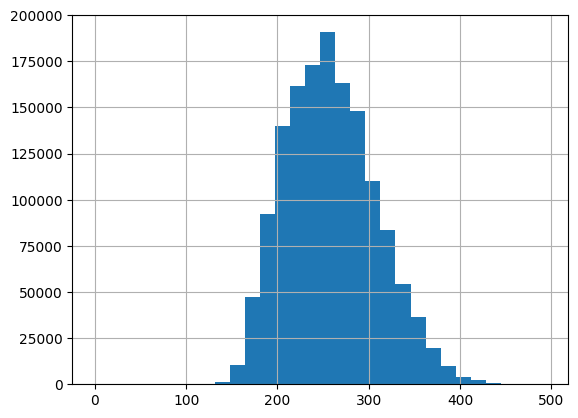

In [ ]:
pdf_icf = df00_Icf.select("PUNT_GLOBAL").toPandas()
pdf_icf["PUNT_GLOBAL"].hist(bins=30)

## Visión general - Internet_Fijo_Penetracion_Municipio_20250521_Limpio.csv

In [ ]:
df00_Int.printSchema()

root
 |-- AÑO: integer (nullable = true)
 |-- TRIMESTRE: integer (nullable = true)
 |-- COD_DEPARTAMENTO: integer (nullable = true)
 |-- DEPARTAMENTO: string (nullable = true)
 |-- COD_MUNICIPIO: integer (nullable = true)
 |-- MUNICIPIO: string (nullable = true)
 |-- No. ACCESOS FIJOS A INTERNET: integer (nullable = true)
 |-- POBLACIÓN DANE: integer (nullable = true)
 |-- INDICE: double (nullable = true)



In [ ]:
df00_Int.show(5, truncate=False)

+----+---------+----------------+------------+-------------+-------------+----------------------------+--------------+------+
|AÑO |TRIMESTRE|COD_DEPARTAMENTO|DEPARTAMENTO|COD_MUNICIPIO|MUNICIPIO    |No. ACCESOS FIJOS A INTERNET|POBLACIÓN DANE|INDICE|
+----+---------+----------------+------------+-------------+-------------+----------------------------+--------------+------+
|2016|1        |50              |META        |50606        |RESTREPO     |490                         |17648         |2.78  |
|2016|2        |15              |BOYACÁ      |15518        |PAJARITO     |43                          |2395          |1.8   |
|2020|3        |25              |CUNDINAMARCA|25489        |NIMAIMA      |43                          |3808          |1.13  |
|2020|3        |73              |TOLIMA      |73030        |AMBALEMA     |38                          |6752          |0.56  |
|2017|1        |5               |ANTIOQUIA   |5690         |SANTO DOMINGO|337                         |12426         |

In [ ]:
df00_Int.describe().show()

+-------+------------------+------------------+------------------+------------+------------------+---------+--------------------+------------------+-----------------+
|summary|               AÑO|         TRIMESTRE|  COD_DEPARTAMENTO|DEPARTAMENTO|     COD_MUNICIPIO|MUNICIPIO|ACESSO_FIJO_INTERNET|    POBLACIÓN DANE|           INDICE|
+-------+------------------+------------------+------------------+------------+------------------+---------+--------------------+------------------+-----------------+
|  count|             35578|             35578|             35578|       35578|             35578|    35578|               35578|             35578|            35578|
|   mean|2019.2601326662543|2.5000843217718813|37.779920175389286|        NULL|38211.710354713585|     NULL|   6633.804766990837| 44491.30788689639|4.498820057338791|
| stddev|2.3311547789013436|1.1178485582544055| 26.17113628351531|        NULL| 26152.92116560164|     NULL|   67065.73359861718|261170.14884452784|5.976250890367004

In [ ]:
df00_Int.select([
    _sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in df00_Int.columns
]).show()

+---+---------+----------------+------------+-------------+---------+--------------------+--------------+------+
|AÑO|TRIMESTRE|COD_DEPARTAMENTO|DEPARTAMENTO|COD_MUNICIPIO|MUNICIPIO|ACESSO_FIJO_INTERNET|POBLACIÓN DANE|INDICE|
+---+---------+----------------+------------+-------------+---------+--------------------+--------------+------+
|  0|        0|               0|           0|            0|        0|                   0|             0|     0|
+---+---------+----------------+------------+-------------+---------+--------------------+--------------+------+



In [ ]:
numeric_cols_icf = [c for c, t in df00_Int.dtypes if t in ("int", "bigint", "double", "float")]
df00_Int.select(numeric_cols_icf) \
    .summary("count", "mean", "stddev", "min", "25%", "50%", "75%", "max") \
    .show()

+-------+------------------+------------------+------------------+------------------+--------------------+------------------+-----------------+
|summary|               AÑO|         TRIMESTRE|  COD_DEPARTAMENTO|     COD_MUNICIPIO|ACESSO_FIJO_INTERNET|    POBLACIÓN DANE|           INDICE|
+-------+------------------+------------------+------------------+------------------+--------------------+------------------+-----------------+
|  count|             35578|             35578|             35578|             35578|               35578|             35578|            35578|
|   mean|2019.2601326662543|2.5000843217718813|37.779920175389286|38211.710354713585|   6633.804766990837| 44491.30788689639|4.498820057338791|
| stddev|2.3311547789013436|1.1178485582544055| 26.17113628351531| 26152.92116560164|   67065.73359861718|261170.14884452784|5.976250890367004|
|    min|              2015|                 1|                 5|              5001|                   1|               262|           

## Visión general - RedVolucion_20250521_Limpio.csv

In [ ]:
df00_Inv.printSchema()

root
 |-- DEPARTAME_NOMBRE: string (nullable = true)
 |-- MUNICIPIO_NOMBRE: string (nullable = true)
 |-- TotalPersonasSencibilizadas: integer (nullable = true)
 |-- COD DANE INST EDUC: long (nullable = true)
 |-- MUNICIPIO_COD: integer (nullable = true)
 |-- FECHA DE CARGUE: date (nullable = true)
 |-- ID INDICADOR: integer (nullable = true)
 |-- INVERSION_TOTAL: double (nullable = true)
 |-- FECHA VIGENCIA: date (nullable = true)
 |-- META_NACIONAL: integer (nullable = true)



In [ ]:
df00_Inv.show(5, truncate=False)

+----------------+----------------+---------------------------+------------------+-------------+---------------+------------+---------------+--------------+-------------+
|DEPARTAME_NOMBRE|MUNICIPIO_NOMBRE|TotalPersonasSencibilizadas|COD DANE INST EDUC|MUNICIPIO_COD|FECHA DE CARGUE|ID INDICADOR|INVERSION_TOTAL|FECHA VIGENCIA|META_NACIONAL|
+----------------+----------------+---------------------------+------------------+-------------+---------------+------------+---------------+--------------+-------------+
|TOLIMA          |FLANDES         |19                         |173275000428      |73275        |2016-12-31     |3979        |1682304.93     |2016-12-31    |48000        |
|TOLIMA          |IBAGUE          |41                         |173001003684      |73001        |2015-12-31     |3101        |3043725.71     |2015-12-31    |34000        |
|VALLE DEL CAUCA |CARTAGO         |95                         |176147000236      |76147        |2016-12-31     |3979        |8411524.68     |2016

In [ ]:
df00_Inv.describe().show()

+-------+----------------+----------------+---------------------------+--------------------+-----------------+-----------------+------------------+-----------------+
|summary|DEPARTAME_NOMBRE|MUNICIPIO_NOMBRE|TotalPersonasSencibilizadas|  COD DANE INST EDUC|    MUNICIPIO_COD|     ID INDICADOR|   INVERSION_TOTAL|    META_NACIONAL|
+-------+----------------+----------------+---------------------------+--------------------+-----------------+-----------------+------------------+-----------------+
|  count|            6682|            6682|                       6682|                6682|             6682|             6682|              6682|             6682|
|   mean|            NULL|            NULL|          82.25875486381322|1.849766306551863E11| 38734.2499251721|4210.358575276863|2554394.8951675864|77184.22627955701|
| stddev|            NULL|            NULL|         217.69551480684436|1.021769097520962...|26681.74219742981|1629.713745940243| 3734024.891476186|80447.63359386739|
|   

In [ ]:
df00_Inv.select([
    _sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in df00_Inv.columns
]).show()

+----------------+----------------+---------------------------+------------------+-------------+---------------+------------+---------------+--------------+-------------+
|DEPARTAME_NOMBRE|MUNICIPIO_NOMBRE|TotalPersonasSencibilizadas|COD DANE INST EDUC|MUNICIPIO_COD|FECHA DE CARGUE|ID INDICADOR|INVERSION_TOTAL|FECHA VIGENCIA|META_NACIONAL|
+----------------+----------------+---------------------------+------------------+-------------+---------------+------------+---------------+--------------+-------------+
|               0|               0|                          0|                 0|            0|              0|           0|              0|             0|            0|
+----------------+----------------+---------------------------+------------------+-------------+---------------+------------+---------------+--------------+-------------+



In [ ]:
numeric_cols_inv = [c for c, t in df00_Inv.dtypes if t in ("int", "bigint", "double", "float")]
df00_Inv.select(numeric_cols_inv) \
    .summary("count", "mean", "stddev", "min", "25%", "50%", "75%", "max") \
    .show()

+-------+---------------------------+--------------------+-----------------+-----------------+------------------+-----------------+
|summary|TotalPersonasSencibilizadas|  COD DANE INST EDUC|    MUNICIPIO_COD|     ID INDICADOR|   INVERSION_TOTAL|    META_NACIONAL|
+-------+---------------------------+--------------------+-----------------+-----------------+------------------+-----------------+
|  count|                       6682|                6682|             6682|             6682|              6682|             6682|
|   mean|          82.25875486381322|1.849766306551863E11| 38734.2499251721|4210.358575276863|2554394.8951675864|77184.22627955701|
| stddev|         217.69551480684436|1.021769097520962...|26681.74219742981|1629.713745940243| 3734024.891476186|80447.63359386739|
|    min|                          1|                   0|             5001|             2344|          14560.68|            18300|
|    25%|                         11|        115820000023|            15238|

# Limpieza por dataset

## df00_Icf --> df05_Icf

In [ ]:
# Paso 1: eliminar PERIODO
df01_Icf = df00_Icf.drop("PERIODO")

Eliminamos PERIODO, porque era un campo combinado (p. ej. “20151”) y ahora ya lo tenemos desglosaste en año y trimestre.

In [ ]:
# Paso 2: eliminar las columnas indicadas
cols_to_drop = [
    "ESTU_CONSECUTIVO",
    "COLE_COD_DANE_ESTABLECIMIENTO",
    "COLE_COD_DANE_SEDE",
    "COLE_CODIGO_ICFES",
    "COLE_COD_DEPTO_UBICACION",
    "ESTU_COD_DEPTO_PRESENTACION",
    "ESTU_COD_MCPIO_PRESENTACION",
    "ESTU_COD_RESIDE_DEPTO",
    "ESTU_COD_RESIDE_MCPIO"
]

df02_Icf = df01_Icf.drop(*cols_to_drop)

Eliminamos los códigos DANE de establecimiento y sede como:

    "ESTU_CONSECUTIVO",
    "COLE_COD_DANE_ESTABLECIMIENTO",
    "COLE_COD_DANE_SEDE",
    "COLE_CODIGO_ICFES",
    "COLE_COD_DEPTO_UBICACION",
    "ESTU_COD_DEPTO_PRESENTACION",
    "ESTU_COD_MCPIO_PRESENTACION",
    "ESTU_COD_RESIDE_DEPTO",
    "ESTU_COD_RESIDE_MCPIO"

que son meros identificadores con miles de valores únicos y no aportan a la mayoría de los análisis.

In [ ]:
from pyspark.sql.functions import when, col
from pyspark.sql.types import BooleanType

# 1. Lista de columnas a binarizar
fam_cols = [
    "COLE_BILINGUE",
    "FAMI_TIENEAUTOMOVIL",
    "FAMI_TIENECOMPUTADOR",
    "FAMI_TIENEINTERNET",
    "FAMI_TIENELAVADORA",
    "COLE_SEDE_PRINCIPAL",
    "ESTU_PRIVADO_LIBERTAD"
]

df03_Icf = df02_Icf
for c in fam_cols:
    df03_Icf = df03_Icf.withColumn(
        c,
        # Cuando sea "Si" o "S" ➔ True, en cualquier otro caso ➔ False
        when((col(c) == "Si") | (col(c) == "S"), True)
        .otherwise(False)
        # forzar el tipo BooleanType
        .cast(BooleanType())
    )

# Comprueba tipos y valores
df03_Icf.select(*fam_cols).printSchema()

root
 |-- COLE_BILINGUE: boolean (nullable = false)
 |-- FAMI_TIENEAUTOMOVIL: boolean (nullable = false)
 |-- FAMI_TIENECOMPUTADOR: boolean (nullable = false)
 |-- FAMI_TIENEINTERNET: boolean (nullable = false)
 |-- FAMI_TIENELAVADORA: boolean (nullable = false)
 |-- COLE_SEDE_PRINCIPAL: boolean (nullable = false)
 |-- ESTU_PRIVADO_LIBERTAD: boolean (nullable = false)



Converitir datos a binarios debido a la simplicidad de si manejo como:

    "COLE_BILINGUE",
    "FAMI_TIENEAUTOMOVIL",
    "FAMI_TIENECOMPUTADOR",
    "FAMI_TIENEINTERNET",
    "FAMI_TIENELAVADORA",
    "COLE_SEDE_PRINCIPAL",
    "ESTU_PRIVADO_LIBERTAD"

Esto nos faacilitara su uso, para comprobaciones booleanas.

In [ ]:
import re
from pyspark.sql.functions import udf, col
from pyspark.sql.types import DoubleType

# 1. Mapa de palabras en español a números
word_to_num = {
    'uno': 1.0, 'dos': 2.0, 'tres': 3.0, 'cuatro': 4.0,
    'cinco': 5.0, 'seis': 6.0, 'siete': 7.0, 'ocho': 8.0,
    'nueve': 9.0, 'diez': 10.0, 'seis o mas': 6.0, 'siete o mas': 7.0,
    'ocho o mas': 8.0, 'nueve o mas': 9.0, 'diez o mas': 10.0
}

# 2. Función de parsing
def parse_numeric(s):
    if s is None:
        return None
    s_l = s.lower()
    # 2a. Rango "x a y"
    if ' a ' in s_l:
        parts = re.findall(r'(\d+)', s_l)
        if len(parts) == 2:
            return (float(parts[0]) + float(parts[1])) / 2
    # 2b. Número simple
    m = re.search(r'(\d+)', s_l)
    if m:
        return float(m.group(1))
    # 2c. Palabra en español
    for w, num in word_to_num.items():
        if w in s_l:
            return num
    return None

# 3. Registra el UDF
parse_numeric_udf = udf(parse_numeric, DoubleType())

# 4. Columnas a convertir
cols_to_numeric = ["FAMI_ESTRATOVIVIENDA", "FAMI_PERSONASHOGAR", "FAMI_CUARTOSHOGAR"]

# 5. Aplica la transformación
df04_Icf = df03_Icf  # parte de tu df anterior
for c in cols_to_numeric:
    df04_Icf = df04_Icf.withColumn(c, parse_numeric_udf(col(c)))

# 6. Comprueba esquema y valores
df04_Icf.select(*cols_to_numeric).printSchema()


root
 |-- FAMI_ESTRATOVIVIENDA: double (nullable = true)
 |-- FAMI_PERSONASHOGAR: double (nullable = true)
 |-- FAMI_CUARTOSHOGAR: double (nullable = true)



Cambiamos valores que si bien son numericos estan como strings y son escritos textualmente como:

    "FAMI_ESTRATOVIVIENDA",
    "FAMI_PERSONASHOGAR",
    "FAMI_CUARTOSHOGAR"

In [115]:
import re
from pyspark.sql.functions import udf, col, when, lower, trim
from pyspark.sql.types import StringType, BooleanType

# 1) UDF que normaliza un string a la etiqueta de categoría
def map_edu_level(s):
    if s is None:
        return None
    x = s.strip().lower()
    # descartar “no sabe”
    if "no sabe" in x:
        return None
    # NINGUNA
    if "ninguno" in x or "no aplica" in x:
        return "NINGUNA"
    # PRIMARIA
    if "primaria" in x:
        return "PRIMARIA_COMPLETA"   if "completa" in x else "PRIMARIA_INCOMPLETA"
    # SECUNDARIA
    if "secundaria" in x or "bachillerato" in x:
        return "SECUNDARIA_COMPLETA"   if "completa" in x else "SECUNDARIA_INCOMPLETA"
    # PREGRADO (educación profesional)
    if "educación profesional" in x:
        return "PREGRADO_COMPLETO"     if "completa" in x else "PREGRADO_INCOMPLETO"
    # TECNICO / TECNOLOGIA
    if "técnica" in x or "tecnológica" in x:
        return "TECNICO_O_TECNOLOGIA_COMPLETA"   if "completa" in x else "TECNICO_O_TECNOLOGIA_INCOMPLETA"
    # POSTGRADO
    if "postgrado" in x:
        return "POSTGRADO"
    return None

map_edu_udf = udf(map_edu_level, StringType())

# 2) Filtrar filas con “No sabe” en madre o padre
df05_Icf = df04_Icf \
    .filter(lower(col("FAMI_EDUCACIONMADRE")).isNotNull()) \
    .filter(lower(col("FAMI_EDUCACIONPADRE")).isNotNull()) \
    .filter(~lower(col("FAMI_EDUCACIONMADRE")).like("%no sabe%")) \
    .filter(~lower(col("FAMI_EDUCACIONPADRE")).like("%no sabe%"))

# 3) Crear columnas intermedias con la categoría normalizada
df05_Icf = df05_Icf \
    .withColumn("madre_cat", map_edu_udf(col("FAMI_EDUCACIONMADRE"))) \
    .withColumn("padre_cat", map_edu_udf(col("FAMI_EDUCACIONPADRE")))

# 4) Lista de categorías
categories = [
    "PRIMARIA_COMPLETA",
    "PRIMARIA_INCOMPLETA",
    "SECUNDARIA_COMPLETA",
    "SECUNDARIA_INCOMPLETA",
    "PREGRADO_COMPLETO",
    "PREGRADO_INCOMPLETO",
    "TECNICO_O_TECNOLOGIA_COMPLETA",
    "TECNICO_O_TECNOLOGIA_INCOMPLETA",
    "POSTGRADO",
    "NINGUNA"
]

# 5) One-hot encoding para madre_cat y padre_cat
for role in ["madre", "padre"]:
    for cat in categories:
        df05_Icf = df05_Icf.withColumn(
            f"{role}_{cat}",
            when(col(f"{role}_cat") == cat, 1).otherwise(0).cast(BooleanType())
        )

# 6) (Opcional) eliminar las columnas originales y las intermedias
df05_Icf = df05_Icf.drop(
    "FAMI_EDUCACIONMADRE",
    "FAMI_EDUCACIONPADRE",
    "padre_cat",
    "madre_cat"
)

# 7) Verificación rápida
df05_Icf.select([c for c in df05_Icf.columns if c.startswith("madre_") or c.startswith("padre_")]) \
         .show(5, truncate=False)


+-----------------------+-------------------------+-------------------------+---------------------------+-----------------------+-------------------------+-----------------------------------+-------------------------------------+---------------+-------------+-----------------------+-------------------------+-------------------------+---------------------------+-----------------------+-------------------------+-----------------------------------+-------------------------------------+---------------+-------------+
|madre_PRIMARIA_COMPLETA|madre_PRIMARIA_INCOMPLETA|madre_SECUNDARIA_COMPLETA|madre_SECUNDARIA_INCOMPLETA|madre_PREGRADO_COMPLETO|madre_PREGRADO_INCOMPLETO|madre_TECNICO_O_TECNOLOGIA_COMPLETA|madre_TECNICO_O_TECNOLOGIA_INCOMPLETA|madre_POSTGRADO|madre_NINGUNA|padre_PRIMARIA_COMPLETA|padre_PRIMARIA_INCOMPLETA|padre_SECUNDARIA_COMPLETA|padre_SECUNDARIA_INCOMPLETA|padre_PREGRADO_COMPLETO|padre_PREGRADO_INCOMPLETO|padre_TECNICO_O_TECNOLOGIA_COMPLETA|padre_TECNICO_O_TECNOLOGIA_INCOMP

Transformamos las variables de educación de los padres realizando un one-hot encoding de las columnas:

    "FAMI_EDUCACIONMADRE",
    "FAMI_EDUCACIONPADRE"

(Primaria completa/incompleta, Secundaria completa/incompleta, Pregrado completo/incompleto, Técnico o tecnología completa/incompleta, Postgrado y Ninguna) en 20 indicadores binarios y eliminamos las filas con “No sabe” para asegurar la limpieza de datos; este cambio convierte información cualitativa en variables numéricas directamente utilizables en análisis y modelos predictivos, reduce la complejidad de texto libre y permite capturar de forma independiente cada nivel educativo, mejorando la comparabilidad y la robustez de la tabla.

In [187]:
df05_Icf = df05_Icf.withColumnRenamed("AÑOS", "AÑO")

In [190]:
from os import truncate
# df05_Icf.select("AÑO").distinct().show(truncate=False)
df05_Icf.show(5)

+------------------+-------------------+-------------+---------------+-----------------+------------------------+--------------------+-----------+------------+--------------------+---------------+---------------------------+--------------------+-------------------+-----------------------+-----------------+------------------------+---------------+--------------------+-----------+-----------------------+-----------------+-----------------+----------------+---------------------+-----------------+--------------------+------------------+-------------------+--------------------+------------------+------------------+-------------+-----------+----------------+------------------------+----------------+--------------------+-----------+----+----------+-----------------------+-------------------------+-------------------------+---------------------------+-----------------------+-------------------------+-----------------------------------+-------------------------------------+---------------+-----

In [120]:
df05_Icf.count()

1374127

## df00_Int --> df04_Int

In [124]:
from pyspark.sql.types import NumericType

# 1. Detecta todas las columnas cuyo tipo sea numérico
numeric_cols_icf = [
    field.name
    for field in df00_Int.schema.fields
    if isinstance(field.dataType, NumericType)
]

print("Columnas numéricas detectadas:", numeric_cols_icf)

# 2. Selecciona sólo esas columnas
numeric_df_icf = df00_Int.select(numeric_cols_icf)

# 3. Muestra un resumen estadístico
numeric_df_icf.describe().show()

# 4. (Opcional) Convierte a pandas y calcula matriz de correlación
#    ¡OJO! Sólo si cabe en memoria local.
pdf_icf = numeric_df_icf.toPandas()
corr_matrix = pdf_icf.corr()
print(corr_matrix)

Columnas numéricas detectadas: ['AÑO', 'TRIMESTRE', 'COD_DEPARTAMENTO', 'COD_MUNICIPIO', 'ACESSO_FIJO_INTERNET', 'POBLACIÓN DANE', 'INDICE']
+-------+------------------+------------------+------------------+------------------+--------------------+------------------+-----------------+
|summary|               AÑO|         TRIMESTRE|  COD_DEPARTAMENTO|     COD_MUNICIPIO|ACESSO_FIJO_INTERNET|    POBLACIÓN DANE|           INDICE|
+-------+------------------+------------------+------------------+------------------+--------------------+------------------+-----------------+
|  count|             35578|             35578|             35578|             35578|               35578|             35578|            35578|
|   mean|2019.2601326662543|2.5000843217718813|37.779920175389286|38211.710354713585|   6633.804766990837| 44491.30788689639|4.498820057338791|
| stddev|2.3311547789013436|1.1178485582544055| 26.17113628351531| 26152.92116560164|   67065.73359861718|261170.14884452784|5.976250890367

In [125]:
df01_Int = df00_Int.drop("COD_MUNICIPIO")
print("Columnas tras paso 1:", df00_Int.columns)

Columnas tras paso 1: ['AÑO', 'TRIMESTRE', 'COD_DEPARTAMENTO', 'DEPARTAMENTO', 'COD_MUNICIPIO', 'MUNICIPIO', 'ACESSO_FIJO_INTERNET', 'POBLACIÓN DANE', 'INDICE']


Eliminamos `COD_MUNICIPIO` porque estaba casi idéntico a `COD_DEPARTAMENTO`, reduciendo la multicolinealidad.

In [126]:
df02_Int = df01_Int \
    .withColumn(
        "PENETRACIÓN_INTERNET",
        col("ACESSO_FIJO_INTERNET") / col("POBLACIÓN DANE")
    ) \
    .drop("ACESSO_FIJO_INTERNET")
print("Columnas tras paso 2:", df02_Int.columns)

Columnas tras paso 2: ['AÑO', 'TRIMESTRE', 'COD_DEPARTAMENTO', 'DEPARTAMENTO', 'MUNICIPIO', 'POBLACIÓN DANE', 'INDICE', 'PENETRACIÓN_INTERNET']


creamos la columna `PENETRACIÓN_INTERNET` (`ACESSO_FIJO_INTERNET` dividido por `POBLACIÓN DANE`) y quitamos el conteo bruto de accesos para normalizar el indicador y hacerlo comparable entre municipios de distinto tamaño.

In [127]:
df03_Int = df02_Int.drop("TRIMESTRE")
print("Columnas tras paso 3:", df03_Int.columns)

Columnas tras paso 3: ['AÑO', 'COD_DEPARTAMENTO', 'DEPARTAMENTO', 'MUNICIPIO', 'POBLACIÓN DANE', 'INDICE', 'PENETRACIÓN_INTERNET']


descartamos `TRIMESTRE` al mostrar prácticamente cero correlación con el índice, quedándonos sólo con `AÑO`, `POBLACIÓN DANE`, `ÍNDICE` y `PENETRACIÓN_INTERNET`

In [168]:
df04_Int = (
    df03_Int
    .filter( (col("AÑO") >= 2015) & (col("AÑO") <= 2018) )
)

Solo vamos a tomar años de 2015 al 2018 ya que son los años en comun entre los tres datasets

In [169]:
df04_Int.groupBy("AÑO") \
    .count() \
    .orderBy("AÑO") \
    .show()

+----+-----+
| AÑO|count|
+----+-----+
|2015| 1104|
|2016| 4421|
|2017| 4420|
|2018| 4433|
+----+-----+



In [166]:
df04_Int.show(5)

+----+----------------+------------+-------------+--------------+------+--------------------+
| AÑO|COD_DEPARTAMENTO|DEPARTAMENTO|    MUNICIPIO|POBLACIÓN DANE|INDICE|PENETRACIÓN_INTERNET|
+----+----------------+------------+-------------+--------------+------+--------------------+
|2016|              50|        META|     RESTREPO|         17648|  2.78|0.027765185856754308|
|2016|              15|      BOYACÁ|     PAJARITO|          2395|   1.8|0.017954070981210855|
|2020|              25|CUNDINAMARCA|      NIMAIMA|          3808|  1.13|0.011292016806722689|
|2020|              73|      TOLIMA|     AMBALEMA|          6752|  0.56|0.005627962085308057|
|2017|               5|   ANTIOQUIA|SANTO DOMINGO|         12426|  2.71|0.027120553677772413|
+----+----------------+------------+-------------+--------------+------+--------------------+
only showing top 5 rows



In [171]:
df04_Int.count()

14378

## df00_Inv --> df06_Inv

In [128]:
from pyspark.sql.types import NumericType

# 1. Detecta todas las columnas cuyo tipo sea numérico
numeric_cols_icf = [
    field.name
    for field in df00_Inv.schema.fields
    if isinstance(field.dataType, NumericType)
]

print("Columnas numéricas detectadas:", numeric_cols_icf)

# 2. Selecciona sólo esas columnas
numeric_df_icf = df00_Inv.select(numeric_cols_icf)

# 3. Muestra un resumen estadístico
numeric_df_icf.describe().show()

# 4. (Opcional) Convierte a pandas y calcula matriz de correlación
#    ¡OJO! Sólo si cabe en memoria local.
pdf_icf = numeric_df_icf.toPandas()
corr_matrix = pdf_icf.corr()
print(corr_matrix)

Columnas numéricas detectadas: ['TotalPersonasSencibilizadas', 'COD DANE INST EDUC', 'MUNICIPIO_COD', 'ID INDICADOR', 'INVERSION_TOTAL', 'META_NACIONAL']
+-------+---------------------------+--------------------+-----------------+-----------------+------------------+-----------------+
|summary|TotalPersonasSencibilizadas|  COD DANE INST EDUC|    MUNICIPIO_COD|     ID INDICADOR|   INVERSION_TOTAL|    META_NACIONAL|
+-------+---------------------------+--------------------+-----------------+-----------------+------------------+-----------------+
|  count|                       6682|                6682|             6682|             6682|              6682|             6682|
|   mean|          82.25875486381322|1.849766306551863E11| 38734.2499251721|4210.358575276863|2554394.8951675864|77184.22627955701|
| stddev|         217.69551480684436|1.021769097520962...|26681.74219742981|1629.713745940243| 3734024.891476186|80447.63359386739|
|    min|                          1|                 

In [130]:
df01_Inv = df00_Inv.drop("COD DANE INST EDUC", "MUNICIPIO_COD")
print("Columnas tras paso 1:", df01_Inv.columns)

Columnas tras paso 1: ['DEPARTAME_NOMBRE', 'MUNICIPIO_NOMBRE', 'TotalPersonasSencibilizadas', 'FECHA DE CARGUE', 'ID INDICADOR', 'INVERSION_TOTAL', 'FECHA VIGENCIA', 'META_NACIONAL']


**Eliminar identificadores:** Tanto `COD DANE INST EDUC` como `MUNICIPIO_COD` son meros códigos con casi cero relación con las otras variables, así que conviene quitarlos para no ensuciar el modelo.

In [143]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

# Step 2: One-hot encoding de ID INDICADOR
# 2.1 Indexar la columna
indexer = StringIndexer(inputCol="ID INDICADOR", outputCol="id_indicador_idx")
df02_Inv = indexer.fit(df01_Inv).transform(df01_Inv)
# 2.2 Aplicar OneHotEncoder
encoder = OneHotEncoder(inputCols=["id_indicador_idx"], outputCols=["id_indicador_ohe"], dropLast=False)
df03_Inv = encoder.fit(df02_Inv).transform(df02_Inv)

df03_Inv = df03_Inv.drop("ID INDICADOR", "id_indicador_idx")

**Tratar `ID INDICADOR` como categoría:** Al vincularse con distintos esquemas de metas, es mejor convertirlo en variable categórica (p. ej. one-hot encoding) o usarlo como factor en el análisis.

In [147]:
df04_Inv = df03_Inv \
    .withColumn("INVERSION_POR_PERSONA", col("INVERSION_TOTAL") / col("TotalPersonasSencibilizadas")) \
    .drop("INVERSION_TOTAL")  # conserva TotalPersonasSencibilizadas + ratio

**Evitar multicolinealidad:** `TotalPersonasSencibilizadas` e `INVERSION_TOTAL` van casi de la mano (r≈0.87). Para predecir alguno de ellos, creamos un ratio (`INVERSION_POR_PERSONA`) y eliminamos el otro.

In [151]:
from pyspark.sql.functions import col, log1p

df05_Inv = df04_Inv.withColumn(
    "log_inversion_por_persona",
    log1p(col("inversion_por_persona"))
)

**Escalado/transformación:** Antes de cualquier modelado, buscamos hacer un log de `INVERSION_TOTAL` y el ratio para suavizar la distribución y mejorar la estabilidad de los coeficientes.

In [179]:
from pyspark.sql.functions import year, col, when

df06_Inv = (
    df05_Inv
      # 1) Extrae año de ambas fechas
      .withColumn("anio_cargue",   year(col("FECHA DE CARGUE")))
      .withColumn("anio_vigencia", year(col("FECHA VIGENCIA")))
      # 2) Define AÑO: si coinciden, usa anio_cargue; si no, usa anio_vigencia
      .withColumn(
          "AÑO",
          when(col("anio_cargue") == col("anio_vigencia"),
               col("anio_cargue")
          ).otherwise(col("anio_vigencia"))
      )
      # 3) Filtra para quedarte solo con años entre 2015 y 2018
      .filter((col("AÑO") >= 2015) & (col("AÑO") <= 2018))
      # 4) Elimina columnas de fecha y temporales
      .drop("FECHA DE CARGUE", "FECHA VIGENCIA", "anio_cargue", "anio_vigencia")
)

# Verifica los años que quedaron
df06_Inv.select("AÑO").distinct().orderBy("AÑO").show()

+----+
| AÑO|
+----+
|2015|
|2016|
|2017|
|2018|
+----+



Eliminamos los años fuera del rango de (2015-2018) y revisamos si `FECHA DE CARGUE` y `FECHA VIGENCIA` son iguales y dejamos solo el año en caso de que no solo dejamos el año de vigencia

In [186]:
renames = {
    "DEPARTAME_NOMBRE": "DEPARTAMENTO",
    "MUNICIPIO_NOMBRE":   "MUNICIPIO",
}

df06_Inv = df06_Inv
for old_name, new_name in renames.items():
    df06_Inv = df06_Inv.withColumnRenamed(old_name, new_name)

In [185]:
df06_Inv.show(5)

+---------------+---------+---------------------------+-------------+----------------+---------------------+-------------------------+----+
|   DEPARTAMENTO|MUNICIPIO|TotalPersonasSencibilizadas|META_NACIONAL|id_indicador_ohe|INVERSION_POR_PERSONA|log_inversion_por_persona| AÑO|
+---------------+---------+---------------------------+-------------+----------------+---------------------+-------------------------+----+
|         TOLIMA|  FLANDES|                         19|        48000|   (6,[0],[1.0])|    88542.36473684211|       11.391247708013143|2016|
|         TOLIMA|   IBAGUE|                         41|        34000|   (6,[1],[1.0])|    74237.21243902438|       11.215034289032058|2015|
|VALLE DEL CAUCA|  CARTAGO|                         95|        48000|   (6,[0],[1.0])|    88542.36505263158|       11.391247711579638|2016|
|          HUILA|     HOBO|                          5|        34000|   (6,[1],[1.0])|            74237.212|       11.215034283118333|2015|
|      MAGDALENA|  P

In [181]:
df06_Inv.count()

5096

# Correlación

In [200]:
df05_Icf.show(5)

+------------------+-------------------+-------------+---------------+-----------------+------------------------+--------------------+-----------+------------+--------------------+---------------+---------------------------+--------------------+-------------------+-----------------------+-----------------+------------------------+---------------+--------------------+-----------+-----------------------+-----------------+-----------------+----------------+---------------------+-----------------+--------------------+------------------+-------------------+--------------------+------------------+------------------+-------------+-----------+----------------+------------------------+----------------+--------------------+-----------+----+----------+-----------------------+-------------------------+-------------------------+---------------------------+-----------------------+-------------------------+-----------------------------------+-------------------------------------+---------------+-----

In [205]:
from pyspark.sql import functions as F

# ================================================================
# 1 ▸ Columnas que vamos a usar
# ================================================================
parent_cols = [
    "madre_PRIMARIA_COMPLETA", "madre_PRIMARIA_INCOMPLETA",
    "madre_SECUNDARIA_COMPLETA", "madre_SECUNDARIA_INCOMPLETA",
    "madre_PREGRADO_COMPLETO", "madre_PREGRADO_INCOMPLETO",
    "madre_TECNICO_O_TECNOLOGIA_COMPLETA", "madre_TECNICO_O_TECNOLOGIA_INCOMPLETA",
    "madre_POSTGRADO", "madre_NINGUNA",
    "padre_PRIMARIA_COMPLETA", "padre_PRIMARIA_INCOMPLETA",
    "padre_SECUNDARIA_COMPLETA", "padre_SECUNDARIA_INCOMPLETA",
    "padre_PREGRADO_COMPLETO", "padre_PREGRADO_INCOMPLETO",
    "padre_TECNICO_O_TECNOLOGIA_COMPLETA", "padre_TECNICO_O_TECNOLOGIA_INCOMPLETA",
    "padre_POSTGRADO", "padre_NINGUNA"
]

cat_cols_target = [
    "COLE_CALENDARIO", "COLE_CARACTER", "COLE_NATURALEZA",
    "COLE_JORNADA", "DEPARTAMENTO", "ESTU_GENERO"
]

# ================================================================
# 2 ▸ Limpieza de cada DataFrame
# ================================================================
# -- 2.1 ▼ df05_Icf (ICFES + nuevas columnas)
df05_clean = (
    df05_Icf
    .withColumn("DEPARTAMENTO", F.upper(F.trim("ESTU_DEPTO_RESIDE")))
    .select(
        "AÑO", "TRIMESTRES", "DEPARTAMENTO",
        "PUNT_GLOBAL", "PUNT_MATEMATICAS", "PUNT_LECTURA_CRITICA",
        "PUNT_SOCIALES_CIUDADANAS", "PUNT_INGLES", "PUNT_C_NATURALES",
        *parent_cols,
        *cat_cols_target
    )
)

# -- 2.2 ▼ df04_Int (penetración de Internet)
df04_agg = (
    df04_Int
    .withColumn("DEPARTAMENTO", F.upper(F.trim("DEPARTAMENTO")))
    .groupBy("AÑO", "DEPARTAMENTO") \
    .agg(F.avg("PENETRACIÓN_INTERNET").alias("PENETRACION_INTERNET")) \
)

# -- 2.3 ▼ df06_Inv (inversión por persona)
df06_agg = (
    df06_Inv
    .withColumn("DEPARTAMENTO", F.upper(F.trim("DEPARTAMENTO")))
    .groupBy("AÑO", "DEPARTAMENTO") \
    .agg(F.avg("INVERSION_POR_PERSONA").alias("INVERSION_POR_PERSONA")) \
)

# -- 2.4 ▼ JOIN definitivo
df_join = (
    df05_clean.alias("icfes")
    .join(df04_agg.alias("int"), ["AÑO", "DEPARTAMENTO"], "inner")
    .join(df06_agg.alias("inv"), ["AÑO", "DEPARTAMENTO"], "inner")
)

### Selección de variables más relevantes

In [212]:
# ================================================================
# 3 ▸ Preparar df_base para ranking de correlaciones
# ================================================================
# -- 3.1 ▼ Booleans → int
bool_cols = [c for c, t in df_join.dtypes if t == "boolean"]

df_base = df_join.select(
    *[F.col(c).cast("int").alias(c) if c in bool_cols else F.col(c)
      for c in df_join.columns]
)

# -- 3.2 ▼ Imputar nulos = 0 en todos los bools
df_base = df_base.fillna(0, subset=bool_cols)

# ================================================================
# 4 ▸ Calcular correlaciones y elegir TOP-20 numéricas
# ================================================================
numeric_cols = [
    c for c, t in df_base.dtypes
    if t in ("int", "double") and c != "PUNT_GLOBAL"
]

corrs = [(c, df_base.stat.corr(c, "PUNT_GLOBAL")) for c in numeric_cols]
corrs_sorted = sorted(corrs, key=lambda x: -abs(x[1]))
top_num = [c for c, _ in corrs_sorted[:20]]

print("===== TOP-20 variables numéricas por |r| contra PUNT_GLOBAL =====")
for col, r in corrs_sorted[:20]:
    print(f"{col:40s}  r = {r:+.3f}")

# ================================================================
# 5 ▸ Ensamblar df_model
# ================================================================
# -- 5.1 ▼ Mantener solo las categóricas que realmente existen
existing_cat_cols = [c for c in cat_cols_target if c in df_base.columns]

cols_final = ["PUNT_GLOBAL"] + top_num + existing_cat_cols

df_model = (
    df_base
    .select(cols_final)
    .na.drop("any")          # cambia estrategia de imputación si quieres
)

# --- chequeo rápido ---
print("\nSchema de df_model")
df_model.printSchema()
print("Filas totales:", df_model.count())
# 1 ▸ ¿Cuántas particiones y registros?
print("Particiones:", df_model.rdd.getNumPartitions())
print("Filas      :", df_model.count())

# 2 ▸ ¿Dónde se gasta tiempo? – plan lógico/físico
df_model.explain(mode="formatted")

# 3 ▸ Muestra rápida sin procesar todo
df_model.sample(False, 0.001).show(10, False)     # 0.1 %

# 4 ▸ Cachear para que show() no vuelva a leer todo
df_model.cache()
df_model.limit(10).show(truncate=False)           # segunda llamada será instantánea

===== TOP-20 variables numéricas por |r| contra PUNT_GLOBAL =====
PUNT_C_NATURALES                          r = +0.910
PUNT_SOCIALES_CIUDADANAS                  r = +0.909
PUNT_MATEMATICAS                          r = +0.906
PUNT_LECTURA_CRITICA                      r = +0.885
PUNT_INGLES                               r = +0.749
madre_PRIMARIA_COMPLETA                   r = -0.262
padre_PREGRADO_COMPLETO                   r = +0.240
padre_PRIMARIA_COMPLETA                   r = -0.238
padre_POSTGRADO                           r = +0.199
madre_POSTGRADO                           r = +0.187
madre_TECNICO_O_TECNOLOGIA_COMPLETA       r = +0.146
padre_TECNICO_O_TECNOLOGIA_COMPLETA       r = +0.125
madre_NINGUNA                             r = -0.113
padre_NINGUNA                             r = -0.110
TRIMESTRES                                r = -0.099
AÑO                                       r = +0.083
madre_PRIMARIA_INCOMPLETA                 r = +nan
madre_SECUNDARIA_COMPLETA          

In [213]:
# 1. Reparte el DataFrame en 1 partición
df_single = df_model.coalesce(1)

# 2. Escríbelo en modo overwrite con cabecera CSV
output_dir = "Resultados_icfes_limpios_temp"
df_single.write \
    .option("header", True) \
    .mode("overwrite") \
    .csv(output_dir)

# 3. Renombra el único part-*.csv al nombre final
import glob, shutil, os

# Busca el archivo CSV generado
part_file = glob.glob(f"{output_dir}/part-*.csv")[0]

# Muévelo y renómbralo
shutil.move(part_file, "Resultados_icfes_limpios.csv")

# 4. Borra el directorio temporal
shutil.rmtree(output_dir)


### Gráficas

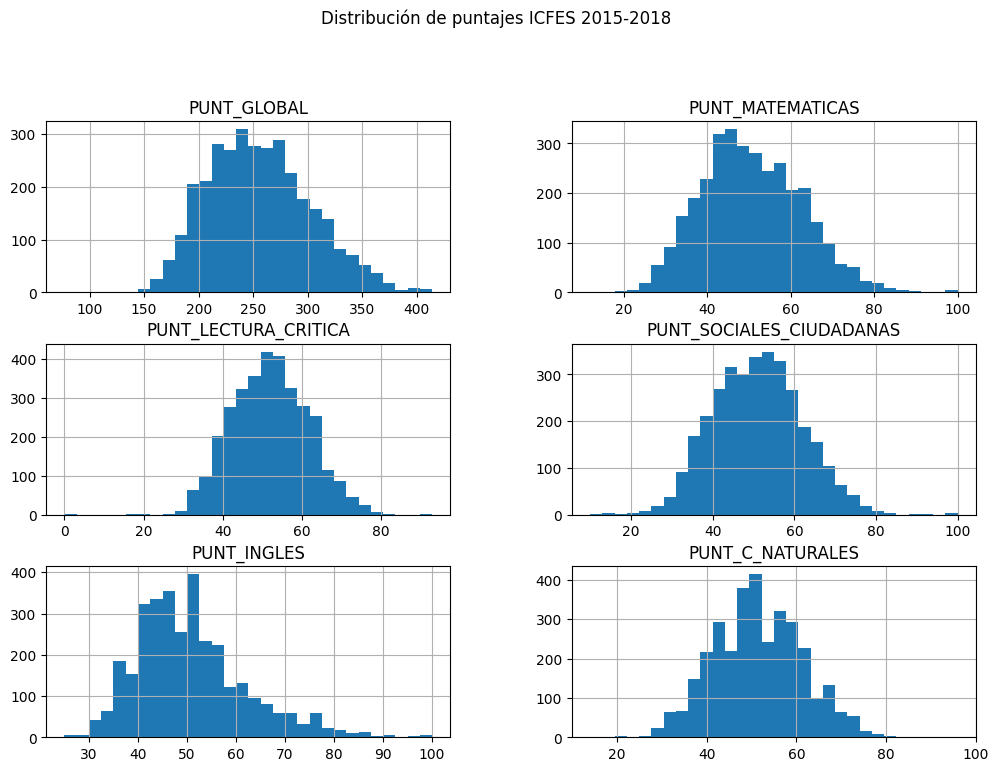

In [218]:
import matplotlib.pyplot as plt
import seaborn as sns

pdf = df_model.select(
    "PUNT_GLOBAL",
    "PUNT_MATEMATICAS",
    "PUNT_LECTURA_CRITICA",
    "PUNT_SOCIALES_CIUDADANAS",
    "PUNT_INGLES",
    "PUNT_C_NATURALES"
).sample(False, 0.005).toPandas()

pdf.hist(bins=30, figsize=(12,8))
plt.suptitle("Distribución de puntajes ICFES 2015-2018", y=1.02)
plt.show()


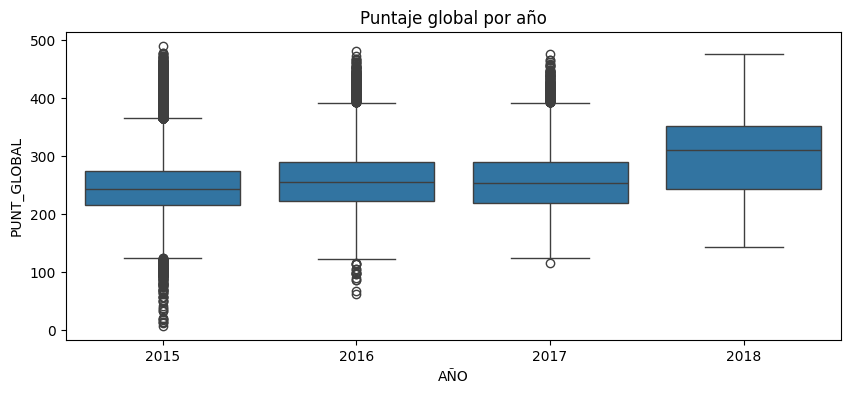

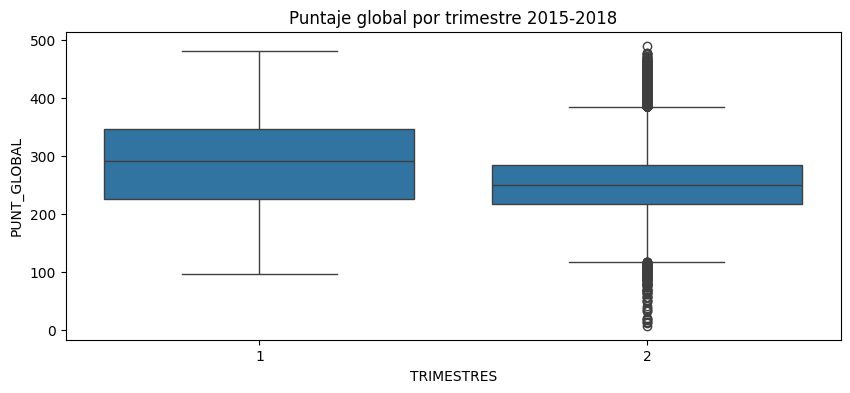

In [220]:
plt.figure(figsize=(10,4))
sns.boxplot(data=df_model.select("AÑO", "PUNT_GLOBAL").toPandas(),
            x="AÑO", y="PUNT_GLOBAL")
plt.title("Puntaje global por año")
plt.show()

plt.figure(figsize=(10,4))
sns.boxplot(data=df_model.select("TRIMESTRES", "PUNT_GLOBAL").toPandas(),
            x="TRIMESTRES", y="PUNT_GLOBAL")
plt.title("Puntaje global por trimestre 2015-2018")
plt.show()

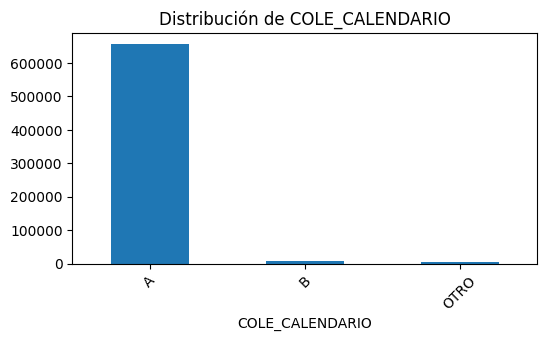

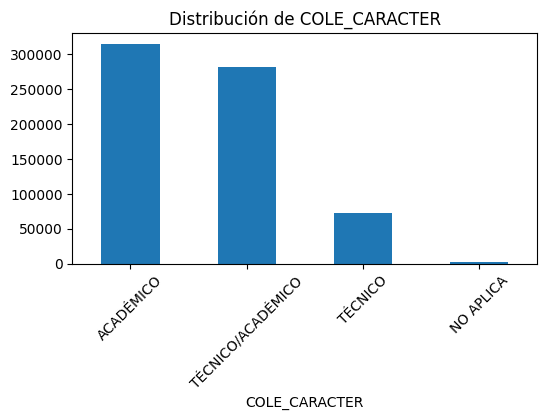

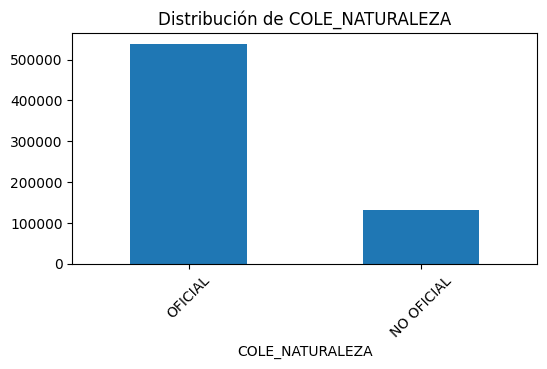

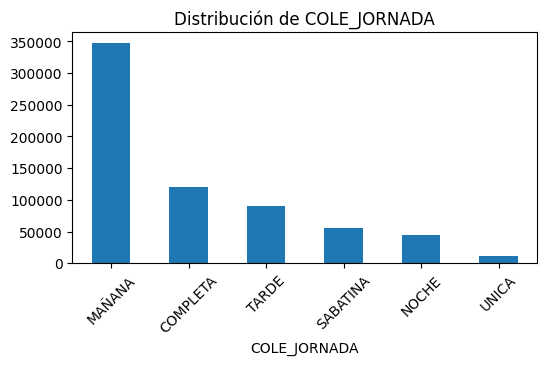

In [221]:
for col in ["COLE_CALENDARIO", "COLE_CARACTER", "COLE_NATURALEZA", "COLE_JORNADA"]:
    (df_model
        .groupBy(col).count()
        .orderBy("count", ascending=False)
        .toPandas()
        .plot.bar(x=col, y="count", legend=False, figsize=(6,3), rot=45)
    )
    plt.title(f"Distribución de {col}")
    plt.show()